##Setups/Imports

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset,Subset,Dataset
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

start_date = '2021-05-12'
end_date = '2023-05-10'

ticker = 'AAPL'
data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-05-12 09:30:00-04:00,123.875603,124.639999,123.550003,123.550003,123.550003,21813410
2021-05-12 10:30:00-04:00,123.559998,123.730003,122.830002,123.169998,123.169998,15510933
2021-05-12 11:30:00-04:00,123.169998,123.379997,122.320000,122.830002,122.830002,13643402
2021-05-12 12:30:00-04:00,122.820000,123.445000,122.589996,122.866302,122.866302,10455100
2021-05-12 13:30:00-04:00,122.860001,123.089996,122.250000,122.510002,122.510002,9870514
...,...,...,...,...,...,...
2023-05-09 11:30:00-04:00,172.289993,172.399902,171.809998,172.059097,172.059097,4358537
2023-05-09 12:30:00-04:00,172.054993,172.479996,172.020004,172.205002,172.205002,3808782
2023-05-09 13:30:00-04:00,172.210007,172.339798,171.960007,172.270004,172.270004,3038422


###Generate GADF images from time series


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField as GADF

def create_gaf_images(data, image_size=28):
    # Calculate number of days in the data
    num_days = len(data) // (image_size)

    # Reshape the data into a 3D array of shape (num_days, 6, 1)
    data = data[:num_days*image_size].reshape(num_days, image_size)

    # print(data.shape)
    close_prices=[]
    for i in range(num_days):
        close_prices.append(np.mean(data[i]))

    # Initialize empty arrays to store the GAF images and closing prices
    # gaf_images = np.empty((num_days, image_size, image_size))
    # closing_prices = np.empty(num_days)
    gadf = GADF(image_size=image_size)
    gadf_images= gadf.fit_transform(data)
    return gadf_images,close_prices
    # Loop through each day of data
    # for i in range(num_days):
    #     # Extract the closing price for the day
    #     closing_prices[i] = data[i][-1]

    #     # Calculate the GADF matrix for the day's data
    #     gadf = GADF(image_size=image_size)
    #     print(data[i])
    #     x_gadf = gadf.fit_transform(data[i])

    #     # Plot the GADF matrix
    #     fig, ax = plt.subplots(figsize=(1, 1))
    #     ax.imshow(x_gadf[0], cmap='gray', origin='lower')
    #     ax.axis('off')

    #     # Convert the plot to an image and store it in the gaf_images array
    #     fig.canvas.draw()
    #     img = np.array(fig.canvas.renderer._renderer)
    #     img = img[:, :, 0]  # take only one channel
    #     gaf_images[i] = img

    return gaf_images, closing_prices

close= np.array(data['Close'])
print(len(close))

gaf_images,close_prices= create_gaf_images(close,30)

3506


In [ ]:
print(gaf_images.shape)

(116, 30, 30)


(30, 30)

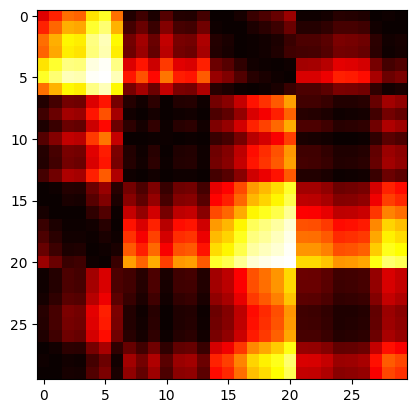

In [ ]:
plt.imshow(gaf_images[0],cmap='hot')
gaf_images[0].shape

In [ ]:
def get_for_whole(data):
    images=[]
    prices=[]
    data1= data.drop(columns=['Volume'])
    for idx, i in enumerate(data1.columns):
      if(idx<1 or idx>3):
        continue
      close= np.array(data1[i])
      gaf_images,close_prices= create_gaf_images(close,30)
      images.append(gaf_images)
      if(i=='Close'):
        prices.append(close_prices)
    images= np.transpose(images, (1, 0, 2, 3))
    # print(np.array(images).shape)
    return np.array(images), prices

images, prices= get_for_whole(data)

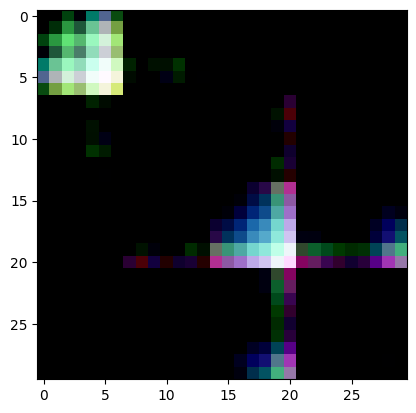

In [ ]:
image= images[0]
image= np.transpose(image, (1, 2, 0))
plt.imshow(image)

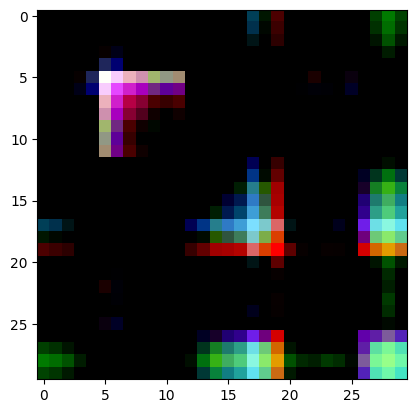

In [ ]:
image= images[1]
image= np.transpose(image, (1, 2, 0))
plt.imshow(image)

##Generate Encodeings by using CNN's on GADF images


In [ ]:
# Define a function to generate random noise image
def generate_noise_image():
    return torch.rand((1, 3, 224, 224)) # Returns a random tensor of size 1x3x224x224

# Define a function to preprocess input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image

# Define a function to get embeddings from ResNet model
def get_resnet_embeddings(image_path=None):

    resnet = models.resnet50(pretrained=True)
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if image_path is None:
        image = generate_noise_image() # Use a sample image if no input image is provided
    else:
        image = preprocess_image(image_path)
    embeddings = resnet(image)
    return embeddings

# Define a function to get embeddings from DenseNet model
def get_densenet_embeddings(image_path=None):
    densenet = models.densenet121(pretrained=True)
    densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
    if image_path is None:
        image = generate_noise_image()  # Use a sample image if no input image is provided
    else:
        image = preprocess_image(image_path)
    embeddings = densenet(image)
    return embeddings

##Forecasting Using LSTM's


### Simple LSTM





In [ ]:
class LstmNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(LstmNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def prepare_dataset(data,length):
    x = []
    y = []
    for i in range(len(data)-length-1):
        x.append(data[i:i+length])
        y.append(data[i+length]) #Only need output for 'Global_active_power'
    return np.array(x),np.array(y)
def train_test_split(X,Y,percent):
    per = percent/100
    sz = len(X)
    xtrain = torch.Tensor(X[:int(sz*per)])
    ytrain = torch.Tensor(Y[:int(sz*per)])
    xtest = torch.Tensor(X[int(sz*per):])
    ytest = torch.Tensor(Y[int(sz*per):])
    return xtrain,ytrain,xtest,ytest
class DataPrep(Dataset):
  def __init__(self, inputs, targets):
      self.inputs = inputs
      self.targets = targets
  def __len__(self):
      return len(self.inputs)

  def __getitem__(self, index):
      X = self.inputs[index]
      Y = self.targets[index]
      return X, Y

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

values = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
seq_len = 40
data_inp,data_tar = prepare_dataset(values,seq_len)
xtrain,ytrain,xtest,ytest = train_test_split(data_inp,data_tar,80)

In [ ]:
traindata = DataPrep(xtrain,ytrain)
testdata = DataPrep(xtest,ytest)

In [ ]:
batch_size = 32
trainset = DataLoader(traindata,batch_size = batch_size,shuffle = True)
testset = DataLoader(testdata,batch_size = batch_size,shuffle = True)

In [ ]:
for xbatch,ybatch in trainset:
    print(xbatch.shape,ybatch.shape)
    break

torch.Size([32, 40, 1]) torch.Size([32, 1])


In [ ]:
train_losses = []
test_losses = []
input_sz = 1
hidden_sz = 100
output_sz = 1
layers = 1
model = LstmNet(input_sz,hidden_sz,layers,output_sz).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
for epoch in range(100):
    batch_loss = 0
    # correct = 0
    for xbatch,ybatch in trainset:
        xbatch,ybatch = xbatch.to(device),ybatch.to(device)
        out = model(xbatch)
        # print(ybatch.shape,out.shape)
        loss = criterion(out, ybatch.squeeze(1))
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        # break
    # break
    train_loss = batch_loss/len(trainset)
    batch_loss = 0
    with torch.no_grad():
        for xbatch,ybatch in testset:
            xbatch,ybatch = xbatch.to(device),ybatch.to(device)
            out = model(xbatch)
            loss = criterion(out, ybatch.squeeze(1))
            batch_loss += loss.item()
    test_loss = batch_loss/len(testset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if(epoch%10==9):
        print("Epoch: ",epoch+1,end = " ")
        print("|",end = " ")
        print("Train Loss : ","{:.6f}".format(train_loss),end = " ")
        print("|",end = " ")
        print("Test Loss : ","{:.6f}".format(test_loss))


In [ ]:
train_pred = model(xtrain.to(device)).cpu().data.numpy()
train_actual = ytrain.data.numpy()
test_pred = model(xtest.to(device)).cpu().data.numpy()
test_actual = ytest.data.numpy()

pred = np.concatenate((train_pred,test_pred))
# pred = scaler.inverse_transform(pred)
actual = np.concatenate((train_actual,test_actual)).squeeze()
# actual = scaler.inverse_transform(pred)
print(pred.shape)
print(actual.shape)

(3465,)
(3465,)


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
trace2 = go.Scatter(x = [(i+1) for i in range(len(actual))],y = actual, name='Actual data')

datas = [trace1,trace2]

layout = go.Layout(title='Prediction for 80:20 split Normal LSTM')
fig = go.Figure(data=datas, layout=layout)
fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

fig.show()

### Image Data Prep


In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 10
data_size = 10
# method = 'difference' # or
method = 'summation'
sample_range = (0, 1)

for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+32])
    images.append(gadf_image)
    labels.append(values[:,i+32+1])
images = np.array(images).astype(np.float32)
labels = np.array(labels)

# scaler= MinMaxScaler()
scaler = StandardScaler()

# labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)



NameError: ignored

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(labels, bins = 20)

# Show plot
plt.show()

In [ ]:
plt.imshow(images[40].transpose(1,2,0),cmap='hot')

### Train Test Split

In [ ]:

from torch.utils.data import DataLoader,ConcatDataset, TensorDataset,Subset,Dataset
from sklearn.model_selection import train_test_split
class DataPrep(Dataset):
  def __init__(self, inputs, targets):
      self.inputs = inputs
      self.targets = targets
  def __len__(self):
      return len(self.inputs)

  def __getitem__(self, index):
      X = self.inputs[index]
      Y = self.targets[index]
      return X, Y
def split_prepare_data(dataset,batch_size = 32,test_size = 0.2):
    train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_idx)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    return train_loader,test_loader

In [ ]:
def prepare_dataset(input,labels,length):
    x = []
    y = []
    for i in range(len(input)-length-1):
        x.append(input[i:i+length])
        y.append(labels[i+length]) #Only need output for 'Global_active_power'
    return np.array(x),np.array(y)
def prepare_dataset_fromone(input,length):
    x = []
    y = []
    for i in range(len(input)-length-1):
        x.append(input[i:i+length])
        y.append(input[i+length])
    return np.array(x),np.array(y)

### LSTM Image MODEL

In [ ]:
from pyts.image import GramianAngularField
from sklearn.preprocessing import StandardScaler,MinMaxScaler
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 32
data_size = 32
# method = 'difference' # or
method = 'summation'
sample_range = (0, 1)

for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
    images.append(gadf_image)
    labels.append(values[:,i+data_size+1])
images = np.array(images).astype(np.float32).reshape(-1,image_size*image_size)
# labels = np.array(labels).astype(np.float32)

# scaler= MinMaxScaler()
scaler = StandardScaler()

labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)

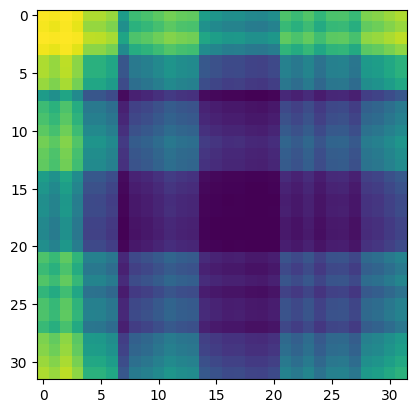

In [ ]:
plt.imshow(images[0].reshape(32,32))

In [ ]:
print(images.shape,labels.shape)

(3473, 1024) (3473,)


In [ ]:
seq_images,seq_labels = prepare_dataset(images,labels,length = 40)
print(seq_images.shape,labels.shape)

(3432, 40, 1024) (3473,)


In [ ]:
dataset = DataPrep(seq_images,seq_labels)
train_loader,test_loader = split_prepare_data(dataset,batch_size = 32)

In [ ]:
print(dataset[0][0].shape)

(40, 1024)


In [ ]:
for xbatch,ybatch in train_loader:
    print(xbatch.shape,ybatch.shape)
    break

torch.Size([32, 40, 1024]) torch.Size([32])


In [ ]:
print(len(train_loader)*32,len(test_loader)*32)

2752 704


In [ ]:
class ImageLSTMNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(ImageLSTMNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)

In [ ]:
train_losses = []
test_losses = []
input_sz = 32*32
# input_sz = LATENT_SIZE
hidden_sz = 2048
output_sz = 1
layers = 1
LSTMmodel = ImageLSTMNet(input_sz,hidden_sz,layers,output_sz).to(device)
# model = LSTM(input_sz,hidden_sz,layers,output_sz).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.0001)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    pbar = tqdm(total = len(train_loader))
    for xbatch,ybatch in train_loader:
        optimizer.zero_grad()
        xbatch, ybatch = xbatch.to(device),ybatch.to(device)
        output = LSTMmodel(xbatch)
        loss = criterion(output,ybatch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
        # break
    train_loss /= len(train_loader)
    pbar.close()
    # break
    test_loss = 0.0
    with torch.no_grad():
        for xbatch,ybatch in test_loader:
            xbatch, ybatch = xbatch.to(device),ybatch.to(device)
            output = LSTMmodel(xbatch)
            loss = criterion(output,ybatch)
            test_loss += loss.item()
        test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")



  0%|          | 0/86 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
pred = LSTMmodel(torch.Tensor(seq_images).to(device)).cpu().data.numpy().squeeze()
# train_actual = Y_train.data.numpy()
# test_pred = model(X_test.to(device)).cpu().data.numpy()
# test_actual = Y_test.data.numpy()

# pred = np.concatenate((train_pred,test_pred))
# pred = scaler.inverse_transform(pred)
actual = labels[41:]
# actual = scaler.inverse_transform(pred)
print(pred.shape)
print(actual.shape)

(3439,)
(3439,)


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
trace2 = go.Scatter(x = [(i+1) for i in range(len(labels))],y = actual, name='Actual data')

plot_data = [trace1,trace2]

layout = go.Layout(title='Prediction for 80:20 split')
fig = go.Figure(data=plot_data, layout=layout)
# fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

fig.show()

### LSTM With Encoded Input

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms

from pyts.image import GramianAngularField
from sklearn.preprocessing import StandardScaler,MinMaxScaler

values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 32
data_size = 32
LATENT_SIZE = 1000
# method = 'difference' # or
method = 'summation'
sample_range = (0, 1)


# Define the ResNet model
resnet = models.resnet18(pretrained=True).float()


# Set the model to evaluation mode
resnet.eval()

# Define the preprocessing transformations to be applied to the images before passing them to the model
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization values for ResNet
])


for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+data_size])

    # Convert the 1-channel image to a 3-channel image
    gadf_image = np.transpose(np.repeat(gadf_image, 3, axis=0), (1, 2, 0))
    # print(gadf_image.shape)
    image = preprocess(gadf_image).unsqueeze(0) # add a batch dimension
    # Pass the image through the ResNet model to obtain the feature vector
    with torch.no_grad():
        encoding = resnet(image.float()).squeeze().numpy() # remove the batch dimension and convert to numpy array
    images.append(encoding)
    labels.append(values[:,i+data_size+1])
images = np.array(images)
print(images.shape)
# images = np.array(images).astype(np.float32).reshape(-1,image_size*image_size)
# labels = np.array(labels).astype(np.float32)
# Samples*Latent vector
# scaler= MinMaxScaler()
scaler = StandardScaler()

labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
  4%|▍         | 1.74M/44.7M [00:00<00:02, 18.2MB/s]
  8%|▊         | 3.48M/44.7M [00:00<00:02, 17.1MB/s]
 11%|█▏        | 5.13M/44.7M [00:00<00:02, 16.4MB/s]
 15%|█▌        | 6.88M/44.7M [00:00<00:02, 16.3MB/s]
 19%|█▉        | 8.63M/44.7M [00:00<00:02, 16.2MB/s]
 23%|██▎       | 10.4M/44.7M [00:00<00:02, 16.3MB/s]
 27%|██▋       | 12.1M/44.7M [00:00<00:02, 16.2MB/s]
 31%|███       | 13.9M/44.7M [00:00<00:01, 16.2MB/s]
 35%|███▌      | 15.6M/44.7M [00:01<00:01, 16.3MB/s]
 39%|███▉      | 17.4M/44.7M [00:01<00:01, 16.3MB/s]
 43%|████▎     | 19.1M/44.7M [00:01<00:01, 16.2MB/s]
 47%|████▋     | 20.9M/44.7M [00:01<00:01, 16.2MB/s]
 51%|█████     | 22.6M/44.7M [00:01<00:01, 16.7MB/s]
 54%|█████▍    | 24.2M/44.7M [00:01<00:01, 16.1MB/s]
 58%|█████▊    | 25.9M/44.7M [00:01<00:01, 16.0MB/s]
 62%|██████▏   | 27.6M/44.7

(3480, 1000)


In [ ]:
seq_images,seq_labels = prepare_dataset(images,labels,length = 40)
print(seq_images.shape,labels.shape)

(3439, 40, 1000) (3480,)


In [ ]:
dataset = DataPrep(seq_images,seq_labels)
train_loader,test_loader = split_prepare_data(dataset,batch_size = 32)

In [ ]:
for xbatch,ybatch in train_loader:
    print(xbatch.shape,ybatch.shape)
    break

torch.Size([32, 40, 1000]) torch.Size([32])


In [ ]:
class ImageLSTMNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(ImageLSTMNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)

In [ ]:
train_losses = []
test_losses = []
# input_sz = 32*32
input_sz = LATENT_SIZE
hidden_sz = 2048
output_sz = 1
layers = 1
LSTMmodel = ImageLSTMNet(input_sz,hidden_sz,layers,output_sz).to(device)
# model = LSTM(input_sz,hidden_sz,layers,output_sz).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.0001)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    pbar = tqdm(total = len(train_loader))
    for xbatch,ybatch in train_loader:
        optimizer.zero_grad()
        xbatch, ybatch = xbatch.to(device),ybatch.to(device)
        output = LSTMmodel(xbatch)
        loss = criterion(output,ybatch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
        break
    train_loss /= len(train_loader)
    pbar.close()
    break
    test_loss = 0.0
    with torch.no_grad():
        for xbatch,ybatch in test_loader:
            xbatch, ybatch = xbatch.to(device),ybatch.to(device)
            output = LSTMmodel(xbatch)
            loss = criterion(output,ybatch)
            test_loss += loss.item()
        test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")



NameError: ignored

In [ ]:
pred = LSTMmodel(torch.Tensor(seq_images).to(device)).cpu().data.numpy().squeeze()
# train_actual = Y_train.data.numpy()
# test_pred = model(X_test.to(device)).cpu().data.numpy()
# test_actual = Y_test.data.numpy()

# pred = np.concatenate((train_pred,test_pred))
# pred = scaler.inverse_transform(pred)
actual = labels[41:]
# actual = scaler.inverse_transform(pred)
print(pred.shape)
print(actual.shape)

(3439,)
(3439,)


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
trace2 = go.Scatter(x = [(i+1) for i in range(len(labels))],y = actual, name='Actual data')

plot_data = [trace1,trace2]

layout = go.Layout(title='Prediction for 80:20 split Using Encoder')
fig = go.Figure(data=plot_data, layout=layout)
# fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

fig.show()

### CNN Model Training Loop and Prediction

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 32
data_size = 32
# method = 'difference' # or
method = 'summation'
sample_range = (0, 1)

for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
    images.append(gadf_image)
    labels.append(values[:,i+data_size+1])
images = np.array(images).astype(np.float32)
labels = np.array(labels)

# scaler= MinMaxScaler()
scaler = StandardScaler()

labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)



In [ ]:
dataset = DataPrep(images,labels)
train_loader,test_loader = split_prepare_data(dataset)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
class GAFModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(GAFModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 3, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.resnet = resnet18(weights = True)
        # self.fc1 = nn.Linear(32 * 8 * 8, 256)
        # self.fc1 = nn.Linear(1000,256)
        # self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(1000, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = self.resnet(x)
        # x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
# Assume X_train and y_train are torch tensors of shape (num_samples, num_channels, image_size, image_size) and (num_samples,)
# Assume X_test and y_test are torch tensors of shape (num_samples, num_channels, image_size, image_size) and (num_samples,)

# Define the model
model = GAFModel(input_channels=1, output_size=1).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    pbar = tqdm(total = len(train_loader))
    for xbatch,ybatch in train_loader:
        optimizer.zero_grad()
        xbatch, ybatch = xbatch.to(device),ybatch.to(device)
        output = model(xbatch)
        loss = criterion(output,ybatch)+torch.sum(ybatch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
    train_loss /= len(train_loader)
    pbar.close()

    test_loss = 0.0
    with torch.no_grad():
        for xbatch,ybatch in test_loader:
            xbatch, ybatch = xbatch.to(device),ybatch.to(device)
            output = model(xbatch)
            loss = criterion(output,ybatch)
            test_loss += loss.item()
        test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/10 - Training Loss: 3.6003 - Testing Loss: 1.5553


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/10 - Training Loss: 2.1798 - Testing Loss: 1.6224


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/10 - Training Loss: 1.6783 - Testing Loss: 1.2215


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/10 - Training Loss: 1.5094 - Testing Loss: 1.2189


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/10 - Training Loss: 1.3918 - Testing Loss: 1.0871


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/10 - Training Loss: 1.2507 - Testing Loss: 1.0793


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/10 - Training Loss: 1.2042 - Testing Loss: 1.0092


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/10 - Training Loss: 1.1759 - Testing Loss: 1.0176


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/10 - Training Loss: 1.1558 - Testing Loss: 1.0051


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/10 - Training Loss: 1.1654 - Testing Loss: 1.0182


In [ ]:
pred = model(torch.Tensor(images).to(device)).cpu().data.numpy().squeeze()
# train_actual = Y_train.data.numpy()
# test_pred = model(X_test.to(device)).cpu().data.numpy()
# test_actual = Y_test.data.numpy()

# pred = np.concatenate((train_pred,test_pred))
# pred = scaler.inverse_transform(pred)
actual = labels
# actual = scaler.inverse_transform(pred)
print(pred.shape)
print(actual.shape)

(3480,)
(3480,)


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
trace2 = go.Scatter(x = [(i+1) for i in range(len(labels))],y = labels, name='Actual data')

plot_data = [trace1,trace2]

layout = go.Layout(title='Prediction for 80:20 split Using CNN')
fig = go.Figure(data=plot_data, layout=layout)
# fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

fig.show()

### Testing the whole sequential model

In [ ]:
from torchvision.models import resnet18
class ImageEncoder(nn.Module):
    def __init__(self,pretrained= False,output_shape = 1000):
        super(ImageEncoder,self).__init__()
        self.output_shape = 1000
        self.resnet = resnet18(pretrained = pretrained)
        self.fc1 = None
        if(output_shape!=1000):
            self.fc1 = nn.Linear(1000,output_shape)

    def forward(self,x):
        x = self.resnet(x)
        if(self.fc1!=None):
            x = F.relu(self.fc1(x))
        return x
class ImageGen(nn.Module):
    def __init__(self,input_shape,image_size =32):
        super(ImageGen,self).__init__()
        self.input_shape = input_shape # This is also the window size
        self.fc1 = nn.Linear(input_shape,128)
        self.fc2 = nn.Linear(128,512)
        self.fc3 = nn.Linear(512,image_size*image_size)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
class ImageLSTMNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(ImageLSTMNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)


In [ ]:
type(data['Close'].values)

numpy.ndarray

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
window_size = 40

values = scaler.fit_transform(data['Close'].values.reshape(-1,1))


In [ ]:
xtrain.shape

torch.Size([2777, 40])

In [ ]:
xtrain,ytrain = prepare_dataset_fromone(values,window_size) # n-1*window
xtrain, ytrain = torch.Tensor(xtrain).squeeze(),torch.Tensor(ytrain).squeeze()
print(xtrain.shape,ytrain.shape)

window_size = 40
image_size = 32
# batch_size = 32
latent_vector = 1000
lstm_layers = 1
lstm_hidden_size = 2048
output_size = 1
Generator = ImageGen(window_size,image_size).to(device)
Encoder = ImageEncoder(True,latent_vector).to(device)
LSTMNet = ImageLSTMNet(latent_vector,lstm_hidden_size,lstm_layers,output_size).to(device)
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.0001)

params_dict = {'Generator': Generator.parameters(),
               'Encoder': Encoder.parameters(),
               'LSTM':LSTMNet.parameters()}
params = list(LSTMNet.parameters())+list(Generator.parameters())+list(Encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

train_sz = 0.8
xtest , ytest = xtrain[int(train_sz*len(xtrain)):],ytrain[int(train_sz*len(xtrain)):]
xtrain , ytrain = xtrain[:int(train_sz*len(xtrain))],ytrain[:int(train_sz*len(xtrain))]
print(xtrain.shape)
epochs = 10
for epoch in range(epochs):
    train_loss = 0.0
    pbar = tqdm(total = len(xtrain-window_size))
    # print(len(xtrain-window_size))
    window = window_size*40
    iters = 0
    for i in range(0,len(xtrain)-window,1):
        optimizer.zero_grad()
        xbatch = xtrain[i:i+window].to(device) #[Window,window]
        indexes = []
        j = i+window_size-1
        while(j<i+window):
            indexes.append(j)
            j+=window_size
        # print(indexes,len(indexes))
        ybatch = ytrain[indexes].to(device)
        # print(xbatch.shape,ybatch.shape)
        output = Generator(xbatch).reshape(-1,1,image_size,image_size) #[window,1,32,32]
        output = output.repeat_interleave(3,axis = 1) #[window,3,32,32]
        # print(output.shape)
        output = Encoder(output).reshape(-1,window_size,1000) #[1,window,1000]
        # print(output.shape)
        output = LSTMNet(output) #[1,1] <- reduces the batch size to one because took the previous batch as window
        # print(output.shape,ybatch.shape)
        loss = criterion(output,ybatch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
        iters+=1
    train_loss /= (iters)
    pbar.close()
    test_loss = 0.0
    for i in range(len(xtest)-window_size):
        optimizer.zero_grad()
        xbatch = xtest[i:i+window_size].to(device)
        ybatch = ytest[i+window_size-1].reshape(-1,1).to(device)
        output = Generator(xbatch).reshape(-1,1,image_size,image_size)
        output = output.repeat_interleave(3,axis = 1)
        output = Encoder(output).unsqueeze(0)
        output = LSTMNet(output)
        loss = criterion(output,ybatch)
        test_loss += loss.item()
    test_loss /= (len(xtest)-window_size)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")




torch.Size([3472, 40]) torch.Size([3472])
torch.Size([2777, 40])


  0%|          | 0/2777 [00:00<?, ?it/s]

Epoch 1/10 - Training Loss: 0.0229 - Testing Loss: 1.0827


  0%|          | 0/2777 [00:00<?, ?it/s]

Epoch 2/10 - Training Loss: 0.0097 - Testing Loss: 1.1614


  0%|          | 0/2777 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
image = Generator(xtrain[1:window_size+1].to(device)).reshape(-1,1,image_size,image_size).detach().cpu().numpy()
plt.imshow(np.transpose(image[0],(1,2,0)),cmap = 'hot')

In [ ]:
preds = []
actual = []
pbar = tqdm(total = len(xtrain-window_size))
# print(len(xtrain-window_size))
for i in range(len(xtrain)-window_size):
    optimizer.zero_grad()
    xbatch = xtrain[i:i+window_size].to(device)
    ybatch = ytrain[i+window_size-1].reshape(-1,1).to(device)
    actual.append(ybatch.item())
    output = Generator(xbatch).reshape(-1,1,image_size,image_size)
    output = output.repeat_interleave(3,axis = 1)
    output = Encoder(output).unsqueeze(0)
    output = LSTMNet(output)
    preds.append(output.item())
    pbar.update(1)
pbar.close()
for i in range(len(xtest)-window_size):
    optimizer.zero_grad()
    xbatch = xtest[i:i+window_size].to(device)
    ybatch = ytest[i+window_size-1].reshape(-1,1).to(device)
    actual.append(ybatch.item())

    output = Generator(xbatch).reshape(-1,1,image_size,image_size)
    output = output.repeat_interleave(3,axis = 1)
    output = Encoder(output).unsqueeze(0)
    output = LSTMNet(output)
    preds.append(output.item())


  0%|          | 0/2777 [00:00<?, ?it/s]

In [ ]:
print(len(preds),len(actual))

3392 3392


In [ ]:
print(preds[:10])

[0.022038379684090614, 0.1498817801475525, 0.2800314128398895, 0.3706657290458679, 0.43137937784194946, 0.35596153140068054, 0.6401709318161011, 0.8152884244918823, 0.6022608280181885, 0.5271565914154053]


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = preds, name='Predicted Data')
trace2 = go.Scatter(x = [(i+1) for i in range(len(actual))],y = actual, name='Actual data')

plot_data = [trace1,trace2]

layout = go.Layout(title='Prediction for 80:20 split ')
fig = go.Figure(data=plot_data, layout=layout)
# fig.add_vline(x=len(train_pred), line_width=1, line_dash="dash", line_color="red")

fig.show()